In [1]:
import sys
import os
import random
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import numpy as np
from math import *
from time import time
import random
from astropy.io import ascii
from astropy.table import Table, Column
import pylab as py
from astropy import coordinates as coord
from astropy import units as unit
import subprocess
from scipy import interpolate
import astropy.stats.funcs as st
import pandas as pd

In [2]:
dataFile = "all10mpc.csv"

df = pd.read_csv(dataFile)

for col in df.columns:
    df = df.rename(columns={col:col.strip()})
    
df.head()

,PGC,1PGC,d,l,b,sgl,sgb,T,Bt,Ks,...,Vls,Vpec,SGX,SGY,SGZ,Fil,Name,ID,fil,Gp ID
0,42407,42407,9.33,298.4607,51.1493,126.6907,-6.6799,1.1,8.70,5.0,...,835,135,-5.54,7.43,-1.09,14.0,NGC4594,31,19,11-14 10
1,10217,9892,5.73,136.4978,-0.3269,359.5791,0.8309,4.0,5.85,4.5,...,222,-208,5.72,-0.04,0.08,14.0,Maffei-2,221,14,14-11 11
2,46153,46153,9.02,105.9971,74.2878,76.1990,14.2465,4.0,8.89,5.6,...,561,-116,2.09,8.49,2.22,14.1,NGC5055,210,14,14 -5 5
3,9031,9031,9.97,140.3846,-17.4156,342.9645,-4.7508,3.1,9.70,5.9,...,745,-2,9.50,-2.91,-0.83,14.0,NGC0891,324,14,17 -1 1
4,12209,12209,9.08,247.5239,-57.0424,256.4502,-36.8678,0.1,9.32,5.7,...,693,12,-1.70,-7.06,-5.45,15.0,NGC1291,952,53,53 -9 7


In [3]:
df['D'] = np.sqrt(df.SGX**2+df.SGY**2+df.SGZ**2)

df[['D', 'd']].head(7)

,D,d
0,9.331913,9.33
1,5.720699,5.73
2,9.020898,9.02
3,9.970306,9.97
4,9.079433,9.08
5,3.770623,3.78
6,8.557161,8.56


In [4]:
df.columns

Index(['PGC', '1PGC', 'd', 'l', 'b', 'sgl', 'sgb', 'T', 'Bt', 'Ks', 'logLK',
       'Vls', 'Vpec', 'SGX', 'SGY', 'SGZ', 'Fil', 'Name', 'ID', 'fil', 'Gp ID',
       'D'],
      dtype='object')

(array([ 37.,  15.,  29., 101.,  62.,  47.,  41.,  47.,  43.,  55.]),
 array([0.25 , 1.222, 2.194, 3.166, 4.138, 5.11 , 6.082, 7.054, 8.026,
        8.998, 9.97 ]),
 <a list of 10 Patch objects>)

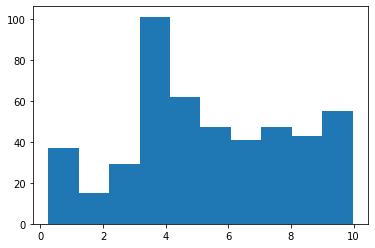

In [5]:
plt.hist(df.d)

In [6]:
# Originally made by M_L_ratio_curve_v2.py
table = np.genfromtxt('M_L_curve_v2.csv', delimiter=',',
                      filling_values=0, names=True, dtype=None)
Lumin_in = 10**table['log10_L']
Mass_out = 10**table['log10_M']

LtoM_func = interpolate.interp1d(Lumin_in, Mass_out)


def Mass(L_k):

    if L_k == 0:
        return 0

    L = L_k / 1.E10

    if L <= 0.0927:
        MtoL = 32.0*(L**-0.5)
    elif L > 0.0927 and L < 4.423:
        return LtoM_func(L_k)
    elif L >= 4.423:
        MtoL = 32*(L**0.15)

    Mass_out = L_k * MtoL

    return Mass_out

In [7]:
def m_logK(Ks, D):
    if D <= 0:
        return 0

    Mk_sun = 3.28   # Ks-band
    M = Ks - 5*np.log10(D) - 30 + 5
    logK = -0.4 * (M - Mk_sun)

    return logK

In [8]:
class GalxyNode:
    
    ID = None
    
    SGX = None
    SGY = None
    SGY = None
    
    logLK = None
    D     = None
    N = None
    Vls = None
    right = None
    left = None
    df = None
    Nest = None
    # Class constructor
    def __init__(self, df=None):
        if df is not None:
            self.data = df
            self.SGX = df.SGX
            self.SGY = df.SGY
            self.SGZ = df.SGZ
            self.D = np.sqrt(df.SGX**2+df.SGY**2+df.SGZ**2)
            self.logLK = m_logK(df.Ks, df.d) # df.logLK
            self.N = 1
            self.Vls = df.Vls 
            self.ID = df.PGC
            self.Nest = df.PGC
            
            mass = Mass(10**df.logLK)
            self.Mass = mass
            self.R2t = 0.215*((mass/1.E12)**(1./3))  # Mpc
            self.r2t = self.R2t*np.sqrt(1.5)  # Mpc
            self.rg = 1.05*self.r2t
            self.Rg = 2.*self.rg/np.pi
            self.inGroup = 0
            self.PGC1 = df['1PGC']
    def setParams(self, ID, SGX, SGY, SGZ, logLK, D, N, Vls):
            self.SGX = SGX
            self.SGY = SGY
            self.SGZ = SGZ
            self.D = D
            self.logLK = logLK
            self.N = N
            self.Vls = Vls   
            self.ID = ID
            
            mass = Mass(10**logLK)
            self.Mass = mass
            self.R2t = 0.215*((mass/1.E12)**(1./3))  # Mpc
            self.r2t = self.R2t*np.sqrt(1.5)  # Mpc
            self.rg = 1.05*self.r2t
            self.Rg = 2.*self.rg/np.pi
            
            self.PGC1 = 0


In [9]:
def readgalList(inFile):

    df = pd.read_csv(inFile)
    for col in df.columns:
        df = df.rename(columns={col:col.strip()})
    N_galaxies = len(df)
    galList = []

    i = 0
    for i in range(N_galaxies):
        node = GalxyNode(df.iloc[i])
        galList.append(node)

    print("No. of galaxies: ", len(galList))
    return galList

In [10]:
GalxyNode(df.iloc[1]).logLK, GalxyNode(df.iloc[1]).data.Ks, GalxyNode(df.iloc[1]).data.logLK

(11.02830924393478, 4.5, 11.03)

In [11]:
i = 50
GalxyNode(df.iloc[i]).data.logLK, m_logK(GalxyNode(df.iloc[i]).data.Ks, GalxyNode(df.iloc[i]).data.d)

(9.54, 9.542799670424541)

In [12]:
galList = readgalList(dataFile)

No. of galaxies:  477


In [13]:
df.iloc[10].PGC

39600

In [14]:
galList[0].data.PGC

42407

In [15]:
def pair_distance(data1, data2):
    
    x1 = data1.SGX
    y1 = data1.SGY
    z1 = data1.SGZ

    x2 = data2.SGX
    y2 = data2.SGY
    z2 = data2.SGZ
    
    return np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
    

In [16]:
def barycenter(L1, data1, L2, data2):

    x1 = data1.SGX
    y1 = data1.SGY
    z1 = data1.SGZ

    x2 = data2.SGX
    y2 = data2.SGY
    z2 = data2.SGZ

    if L1 == 0 and L2 == 0:
        x = 0.5*(x1+x2)
        y = 0.5*(y1+y2)
        z = 0.5*(z1+z2)
    else:
        L = L1 + L2
        x = (L1*x1+L2*x2)/L
        y = (L1*y1+L2*y2)/L
        z = (L1*z1+L2*z2)/L

    d = np.sqrt(x**2+y**2+z**2)

    return L, x, y, z, d

In [17]:
def galJoint(galNode1, galNode2, ID):

    if galNode1 == None and galNode2 != None:
        return galNode2
    if galNode2 == None and galNode1 != None:
        return galNode1
    if galNode2 == None and galNode1 == None:
        return None

    L1 = 10**galNode1.logLK
    L2 = 10**galNode2.logLK

    try:
        logK_tot = log10(L)
    except:
        logK_tot = 0

    L, sgx, sgy, sgz, D = barycenter(L1, galNode1, L2, galNode2)

    n1 = galNode1.N
    n2 = galNode2.N
    Vls = (n1*galNode1.Vls + n2*galNode2.Vls) / (n1+n2)

    newNode = GalxyNode()
    newNode.setParams(ID, sgx, sgy, sgz, np.log10(L), D, n1+n2, Vls)


    # Brighter galaxy is the left child
    if L1 >= L2:
        newNode.left = galNode1
        newNode.right = galNode2
        newNode.Nest = galNode1.Nest
    else:
        newNode.left = galNode2
        newNode.right = galNode1
        newNode.Nest = galNode2.Nest

    return newNode

In [18]:
def LoosgalListJoint(galList, grID=500000000):
    
    Ngal = len(galList)
    if Ngal == 0:
        return None

    Lum = []
    for i in range(Ngal):
        Lum.append(galList[i].logLK)
    Lum = np.asarray(Lum)
    indices = np.argsort(Lum)
#     indices = indices[::-1]

    root = None
    for i in indices:
        root = galJoint(root, galList[i], grID + galList[i].ID)
    
    return root

In [19]:
pp = LoosgalListJoint(galList)

In [20]:
pp.Mass

147019820641126.2

In [21]:
len(galList)

477

In [22]:
galList[0].Mass

8762942829645.955

In [23]:
# It returns all leaf-nodes at the bottom of a gaalxy tree.
# root: is the root of the tree
# It works recursively, so for large trees, it might
# exhaust the recursion stack, and the codes crashe
# so some exception handling is required in this case


def NodeLeaf(root):
    list = [root]
    NodeLeafCore(root, list)
    return list


def NodeLeafCore(root, list):
    if root.left == None:

        list.append(root)
    else:
        NodeLeafCore(root.left, list)
        NodeLeafCore(root.right, list)

## Finding groups given a galaxy list

In [24]:
def IndividualGal(galList_org):

    galList = []
    for galaxy in galList_org:
        if galaxy.inGroup == 0:
            galList.append(galaxy)
            
    individuals = []
    mass = []
    for i in range(0, len(galList)):
        mass.append(galList[i].Mass)
    mass = np.asarray(mass)
    indices = np.argsort(mass)
    for i in indices[::-1]:
        individuals.append(galList[i])

    NEWgpLIST = []
    p = 0
    N = len(individuals)
      
    while p < N-1:
        galaxies = []
        galaxies.append(individuals[p])
        q = (p+1) % N
        pivot = p
        grp = galaxies[0]
        Bol = False
        while q != pivot:

            DD = pair_distance(grp, individuals[q])
            
            if DD <= 1.05*(grp.r2t + individuals[q].r2t):
                
                    galaxies.append(individuals[q])
                    grp = LoosgalListJoint(galaxies, grID=1000000000)
                    individuals.pop(q)
                    
                    Bol = True

                    N -= 1

                    if p >= q:
                        p -= 1

                    if len(galaxies) == 2:
                        individuals.pop(p)
                        N -= 1
                        if q > p:
                            q = (q-1) % N

                    q = (q-1) % N
                    pivot = q

            q = (q+1) % N
        if Bol:
            NEWgpLIST.append(NodeLeaf(grp))
        p += 1

        for i in range(0, len(NEWgpLIST)):
            NEWgpLIST[i][0].inGroup = 2
            for j in range(1, len(NEWgpLIST[i])):
                NEWgpLIST[i][j].inGroup = 1


    return NEWgpLIST

In [25]:
for gal in galList:
    gal.inGroup=0
G_list = IndividualGal(galList)
len(G_list)

35

## Merging Groups if possible

In [26]:
def mergGroup(G_list):

    NoGroups = len(G_list)

    i = 0
    while i < NoGroups:
        j = i+1
        while j < NoGroups-1:

            DD = pair_distance(G_list[i][0], G_list[j][0])
            
            if DD <= G_list[i][0].r2t + G_list[j][0].r2t:

                newGroup = []

                for p in range(1, len(G_list[i])):
                    newGroup.append(G_list[i][p])

                for q in range(1, len(G_list[j])):
                    newGroup.append(G_list[j][q])

                root = LoosgalListJoint(newGroup, grID=2000000000)
                G_list[i] = NodeLeaf(root)

                G_list.pop(j)
                NoGroups -= 1
                i = 0
                j = 0
            j += 1
        i += 1

    return G_list

In [27]:
G_list = mergGroup(G_list)

len(G_list)

35

## Storing the catalog on disk

In [28]:
myTable = Table()

empty = []
myTable.add_column(Column(data=empty, name='PGC', dtype=np.dtype(int)))
myTable.add_column(Column(data=empty, name='G', dtype=np.dtype(int)))
myTable.add_column(Column(data=empty, name='Nest_10Mpc', dtype=np.dtype(int)))
myTable.add_column(Column(data=empty, name='1PGC', dtype=np.dtype(int)))
myTable.add_column(Column(data=empty, name='N', dtype=np.dtype(int)))

myTable.add_column(Column(data=empty, name='SGX', format='%0.2f'))
myTable.add_column(Column(data=empty, name='SGY', format='%0.2f'))
myTable.add_column(Column(data=empty, name='SGZ', format='%0.2f'))
myTable.add_column(Column(data=empty, name='D', format='%0.2f'))
myTable.add_column(Column(data=empty, name='Vls', dtype=np.dtype(int)))
myTable.add_column(Column(data=empty, name='logLK', format='%0.3f'))
myTable.add_column(Column(data=empty, name='Mass', format='%0.4f'))
myTable.add_column(Column(data=empty, name='r2t', format='%0.3f'))

NoGroups = len(G_list)

for i in range(0, NoGroups):  # for all groups
    Nest = G_list[i][0].Nest
    Ngal = G_list[i][0].N
    for j in range(0, len(G_list[i])):  # for all galaxies
        galaxy = G_list[i][j]
        
        myTable.add_row([
                        galaxy.ID,
                        galaxy.inGroup,
                        Nest,
                        galaxy.PGC1,
                        Ngal,
                        galaxy.SGX,
                        galaxy.SGY,
                        galaxy.SGZ,
                        galaxy.D,
                        galaxy.Vls,
                        galaxy.logLK,
                        galaxy.Mass/1.e12,
                        galaxy.r2t
                        ])

individuals = []
for galaxy in galList:
    if galaxy.inGroup <= 0:
        individuals.append(galaxy)

mass = []
for i in range(0, len(individuals)):
    mass.append(individuals[i].Mass)
mass = np.asarray(mass)
indices = np.argsort(mass)

for i in indices[::-1]:
    galaxy = individuals[i]
    myTable.add_row([
                galaxy.ID,
                galaxy.inGroup,
                galaxy.Nest,
                galaxy.PGC1,
                galaxy.N,
                galaxy.SGX,
                galaxy.SGY,
                galaxy.SGZ,
                galaxy.D,
                galaxy.Vls,
                galaxy.logLK,
                galaxy.Mass/1.e12,
                galaxy.r2t
                ])
        
myTable.write('groups_10Mpc.csv', format='ascii.fixed_width', delimiter=',', bookend=False)  

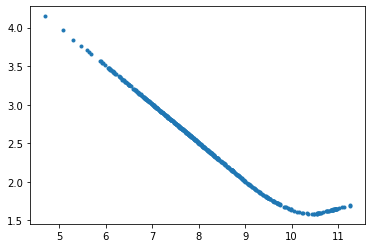

In [29]:
dff = pd.read_csv("groups_10Mpc.csv")

for col in dff.columns:
    dff = dff.rename(columns={col:col.strip()})

plt.plot(dff.logLK, np.log10(dff.Mass*1.e12)-dff.logLK, '.')